## CryoSphere: SO(3)-equivariant method for cryo-EM pose estimation

Dev Chheda, Divya Nori


### Introduction

Cryo-electron microscopy (cryo-EM) is a powerful imaging technique that has transformed structural biology research by enabling high-resolution 3D reconstructions of complex biological macromolecules such as proteins. The process involves collecting tens of thousands of 2D images in a single run, which are then processed using specialized software to generate a detailed 3D model of electron density. One of the key challenges with cryo-EM is that the poses (i.e. 3D orientations) of the 2D images are not known when the images are taken, and so much work revolves around determining the poses of cryo-EM images. 

Despite the significant advancements in cryo-EM technology, current reconstruction algorithms, whether traditional or deep learning-based, are time-consuming and require hundreds of thousands of images to achieve high-resolution reconstructions. To accelerate the processing of cryo-EM data for downstream structural biology tasks, innovative methods for 3D reconstruction from 2D output projections are needed. Specifically, current methods infer a single pose from each cryo-EM image, requiring a high volume of images to reconstruct at high-resolution. However, proteins are highly symmetric, motivating an investigation as to whether multiple poses can be inferred from a single projection image.

In this study, we focus on the task of single-particle analysis, where an individual particle is analyzed from 2D images and then reconstructed in 3D space. Our aim is to develop a pose prediction model that preserves the symmetries present in the data by being equivariant to the group SO(3) of 3D rotations. We investigate whether using SO(3)-equivariant neural networks, specifically spherical CNNs, can successfully perform cryo-EM pose prediction for a downstream reconstruction task.

#### Cryo-EM Problem Setting

Cryo-EM images are 2D projections of 3D electron density volumes, which represent the underlying protein. The 3D electron density volume, $V: \mathbb{R}^3 \rightarrow \mathbb{R}$ maps each point in 3D space to an electron density. Then, the imaging process is modeled as 

$$I(r_x, r_y) = g * \int_{\mathbb{R}} V(R \mathbf{r}) dr_z + \epsilon$$

where $\mathbf{r} = (r_x, r_y, r_z)^T$, $I: \mathbb{R}^2 \rightarrow \mathbb{R}$ is the image, $R \in SO(3)$ is the unknown pose of the 3D protein volume, $g$ is a kernel modeling the microscope blurring effects, and $\epsilon$ is pointwise noise. We call this projection function from the 3D volume to the 2D images $c: V \rightarrow I$. An example of the 3D structure of a protein and multiple (synthetic) 2D images is shown in Figure 1.

<div align="center">
<img src="../figures/projection-diagram.png" width="300" />

Figure 1
</div>

The cryo-EM pose estimation problem is the task of taking some (randomly generated) image $I$ and recovering the unknown pose $R$ that was applied to $V$ during generation of $I$. However, proteins are often highly symmetric, and so for a given image $I$, there may actually be several poses $R$ which would generate images similar to $I$. And so, in this study, we consider a more general version of pose estimation, in which we attempt to account for these underlying symmetries by predicting a probability distribution over all possible poses in $SO(3)$. 


### Related Work

The state-of-the-art learning-based approach for cryo-EM reconstruction is cryoFIRE, which leverages a deep generative model of 3D structure from single-particle 2D images [1]. CryoFIRE adopts an image-to-pose encoder and pose-to-slice decoder architecture, and the model is specified in the Fourier domain to relate 2D images as planar slices in 3D volume as shown in Figure 2. This Fourier-based representation enables the model to efficiently capture detailed particle pose information from images. However, CryoFIRE infers a single pose from each image. To achieve high-resolution reconstructions, CryoFIRE still requires a large number of images, often in the order of hundreds of thousands. While CryoFIRE is capable of handling heterogeneous reconstructions, where the protein may exhibit different conformational changes across images, we will evaluate its efficacy in our homogeneous reconstruction setting, where we assume all 2D images capture the protein at the same conformational state.

<div align="center">
<img src="../figures/cryofire.png" width="500" />

Figure 2
</div>

One prior paper addresses the task of pose prediction using symmetry, and they propose using a single convolutional neural network to predict a set of 3D poses given an input image [2]. They evaluate their model on both real and synthetic datasets, showing success on proteins with low and high degrees of symmetry. However, the model they train is not equivariant. We hypothesize that learning $SO(3)$-equivariant features will improve generalization and sample efficiency.


### Background

To exploit 3D object symmetry for pose prediction, we employ methodology demonstrated in Image2Sphere [3]. Image2Sphere demonstrates that 3D object structure and pose can be predicted successfully from a single image using $SO(3)$-equivariant features.. The method initially utilizes a vanilla convolutional neural network to extract features that are then projected onto a half-sphere. Next, the projected filter undergoes spherical convolution, which results in a signal that is equivariant to $SO(3)$ rotation. Finally, a group convolution yields a probability distribution over $SO(3)$ parameterized in the Fourier domain. 

We employ similar methodology in our task as shown in Figure 3, essentially projecting a learned feature map onto a half-sphere before predicting a probability distribution using spherical convolutions. The output of our model is $P: SO(3) \rightarrow \mathbb{R}$, which indicates a probability map over all orietnations in $SO(3)$. 


<div align="center">
<img src="../figures/method.png" width="500" />

Figure 3
</div>

Given that the projection operation is not equivariant, we aim to learn an sCNN encoder that is approximately equivariant, making our overall pipeline fully equivariant. In particular, if our learned model is $s: I \rightarrow P$, and the 2D projection operation is $c$, we want $s \circ c: V \rightarrow P$ to satisfy $SO(3)$ equivariance: 

$$
(s \circ c) (RV) = R (s \circ c) (V)
$$


We define group action of $R \in SO(3)$ on $V$ and $P$ in the following way:

$$
\begin{align*}
(RV)(\mathbf{r}) &= V(R \mathbf{r}) \, \, \forall \mathbf{r} \in \mathbb{R}^3 \\
(RP)(g) &= P(R^{-1} g) \, \, \forall g \in SO(3)
\end{align*}
$$

### Methods

#### Data Generation

From Protein Data Bank (PDB), we downloaded the 3D electron density map (EDM) of the T20S proteasome, a protein commonly used in cryo-EM studies, and stored in a pickle file after some basic data processing. 


In [12]:
import pickle

# load the processed data set
with open('../data/processed_dataset.pickle', 'rb') as datafile:
    processed_dataset = pickle.load(datafile)

# print the protein PDBs and content keys
for pdb_id, metadata in processed_dataset.items():
    print(f"PDB: {pdb_id}, Fields: {metadata.keys()}")

PDB: 6bdf, Fields: dict_keys(['3D_map', 'structure'])


The `3D_map` of the protein PDBs is the electron density map, which is a rank 3 tensor with densities at each point in 3D space. However, these tensors are often extremely sparse, since most of the values are zeroes. So, for more efficient processing, we convert the 3D map to a *point density array* (PDA) which contains the position and value of all the nonzero values in the 3D map. We also normalize the electron density map before conversion.

In [4]:
# import helper functions from src/projection.py
import projection as proj

# Load the EDM of 6bdf protein and normalized
edm = processed_dataset['6bdf']['3D_map']
normalized_edm = proj.normalize_edm(edm)

# Generate the sparse point-density array
pda = proj.point_density_array(normalized_edm)

# save the generated PDA
with open('../data/pda.pickle', 'wb') as pda_file:
    pickle.dump(pda, pda_file)

We can see a large decrease in compute and memory requirement achieved as a result of our sparse representation of data.

In [14]:
# Data efficiency due to sparse representation
print(f"Sparsity of PDA representation: {pda[0].size}/{edm.size} = {pda[0].size/edm.size} ")

Sparsity of PDA representation: 9245658/27000000 = 0.3424317777777778 


We generate $m$ orthographic projections from unknown orientations, adding Gaussian noise and blurring effects to simulate real experimental conditions. The generation and application of synthetic data in this manner for cryo-EM reconstruction algorithm development is common in prior work. In our actual training/testing loop, we use $m=500$, but this will take 10-15 minutes to run, so here we have set $m=5$ to generate a few examples. We then visualize these projections as images.

In [15]:
# load the PDA from the saved pickle
with open('../data/pda.pickle', 'rb') as pda_file:
    pda = pickle.load(pda_file)

shape = (512, 512)
projection_dict = {}
m = 5 # in actual training/testing we use m=500

# generate projections
projection_dict['6bdf'] = proj.project_pda_to_image(pda, shape=shape, batch_size = m, blur_sigma=(2,2), noise_sigma=0.03)

# save the generated projections
with open('../data/projections-example.pickle', 'wb') as proj_file:
    pickle.dump(projection_dict, proj_file)

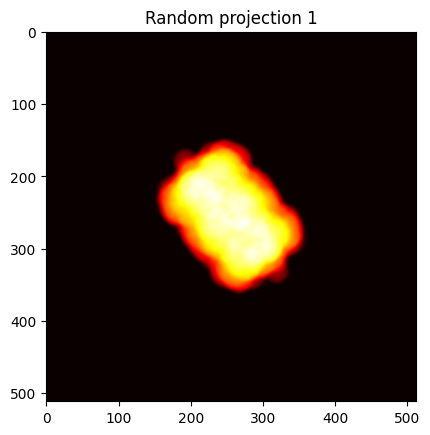

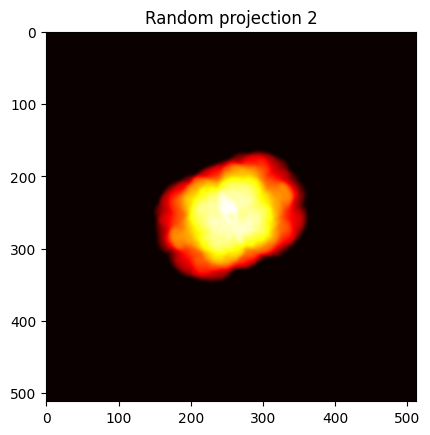

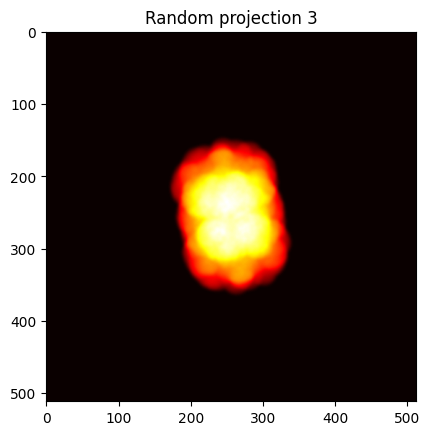

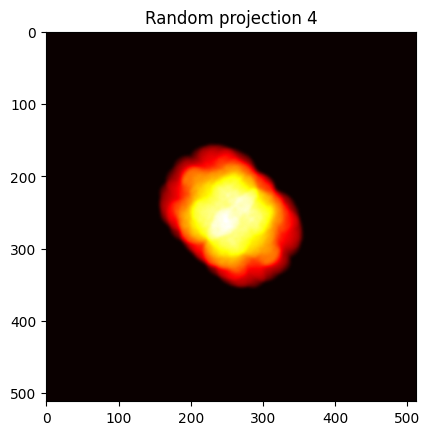

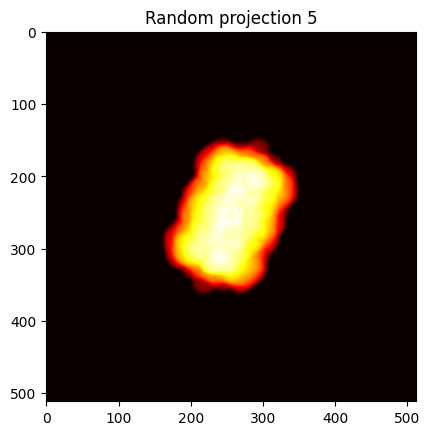

In [26]:
import matplotlib.pyplot as plt

# load projections from pickle
projection_dict = {}
with open('../data/projections-example.pickle', 'rb') as proj_file:
    projection_dict = pickle.load(proj_file)

# visualize as images
for i, im in enumerate(projection_dict['6bdf']):
    plt.imshow(im, cmap='hot')
    plt.title(f'Random projection {i+1}')
    plt.show()


Subsequently, we generated ground truth labels for model training. For each projection image, we initialized a HEALPix grid over $SO(3)$ with a bin width of 15 degrees where each grid cell contains MSE with respect to ground truth image from that pose. By construction, for a given projection image, grid cells corresponding to poses where the ground truth image looks similar will have low MSE. Therefore, these ground truth grids encode protein symmetry. 

We then squared each MSE value, multiplied by -0.0001, and took the exponential. This transformation was applied to produce separation between similar and dissimilar poses and encourage learning of symmetries. To generate a binary mask, the top 5% of the transformed values were labeled as 1, and the remaining were labeled as 0.

#### Model Building

The model architecture consists of three parts – a convolutional network which takes input 2D projection images and outputs a 2D feature map, a projector onto half-sphere, and a spherical convolutional network to output the probability distribution. Specifically, the initial CNN consists of two Conv2d layers and ReLU activation, and the half-sphere projector applies a depthwise convolution operation. The sCNN learns a signal over SO(3) with S2 convolution, SO(3) activation, and SO(3) convolution.

#### Model Training

The model was trained using a binary cross entropy loss between the predicted probability distribution and the ground truth binary mask. The spherical equivariant layers use a lmax = 4, and the model was trained with learning rate 0.001 for 200 epochs.

#### Experiments

First, we ran an experiment to test how the number of training images affects output probability distributions. With 50, 100, 200, and 400 training images, we recorded train ROC and precision-recall after 200 epochs. Results are shown in Table 1.